## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
# %matplotlib inline

In [2]:
df = pd.read_csv('./data/cleaned_df.csv')

## Encoding

In [3]:
#finding the categorical columns
df.select_dtypes(include = 'object').head()

,Education,Marital_Status,Income_Level,Enrollment
0,Bachelor,No_Partner,lower-middle income,2014-03-08
1,Bachelor,Partnership,middle income,2013-08-21
2,Bachelor,Partnership,low income,2014-02-10
3,PhD,Partnership,middle income,2014-01-19
4,Master,Partnership,middle income,2013-09-09


In [4]:
df_encoded = pd.get_dummies(df, columns=['Education', 'Marital_Status', 'Income_Level'], dtype = 'int')
df_encoded

,ID,Age,Enrollment_Age,Tot_Dependents,Household_Size,Income,Tot_Spent,Tot_Purchased,Enrollment,Recency,...,Days_Enrolled,Education_Bachelor,Education_High School,Education_Master,Education_PhD,Marital_Status_No_Partner,Marital_Status_Partnership,Income_Level_low income,Income_Level_lower-middle income,Income_Level_middle income
0,2174,70,60,2,3,46344.0,27,6,2014-03-08,38,...,3728,1,0,0,0,1,0,0,1,0
1,4141,59,48,0,2,71613.0,776,21,2013-08-21,26,...,3927,1,0,0,0,0,1,0,0,1
2,6182,40,30,1,3,26646.0,53,8,2014-02-10,26,...,3754,1,0,0,0,0,1,1,0,0
3,5324,43,33,1,3,58293.0,422,19,2014-01-19,94,...,3776,0,0,0,1,0,1,0,0,1
4,7446,57,46,1,3,62513.0,716,22,2013-09-09,16,...,3908,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,8080,38,26,0,1,26816.0,22,4,2012-08-17,50,...,4296,1,0,0,0,1,0,1,0,0
1446,8372,50,39,1,3,34421.0,30,4,2013-07-01,81,...,3978,1,0,0,0,0,1,0,1,0
1447,7270,43,33,0,1,56981.0,1241,19,2014-01-25,91,...,3770,1,0,0,0,1,0,0,1,0
1448,8235,68,58,1,3,69245.0,843,23,2014-01-24,8,...,3771,0,0,1,0,0,1,0,0,1


In [5]:
df = df_encoded.drop(['ID', 'Enrollment','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response'], axis=1)

In [6]:
features = df.columns.to_list()

## KMeans Model

In [7]:
#scaling features
X = df[features]
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [8]:
#performing pca for dimensionality reduction
pca = PCA(n_components = 0.95) #set to .95 to retain principal components that explain at least 95% of the variance
X_scaled_reduced = pca.fit_transform(X_scaled)

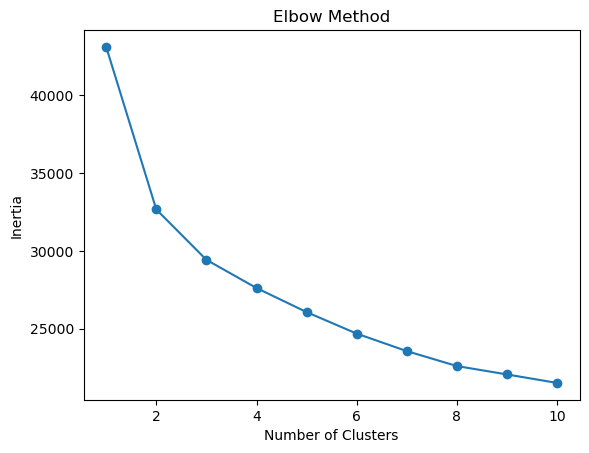

In [9]:
#elbow method to find ideal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled_reduced)
    inertia.append(kmeans.inertia_)
    
#plotting elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

I will use 4 clusters since that is where the rate of decrease in inertia starts to slow down the most, indicating the optimal number of clusters.

In [10]:
#building model
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled_reduced)

In [11]:
#adding cluster labels to the original df
df['Clusters'] = clusters

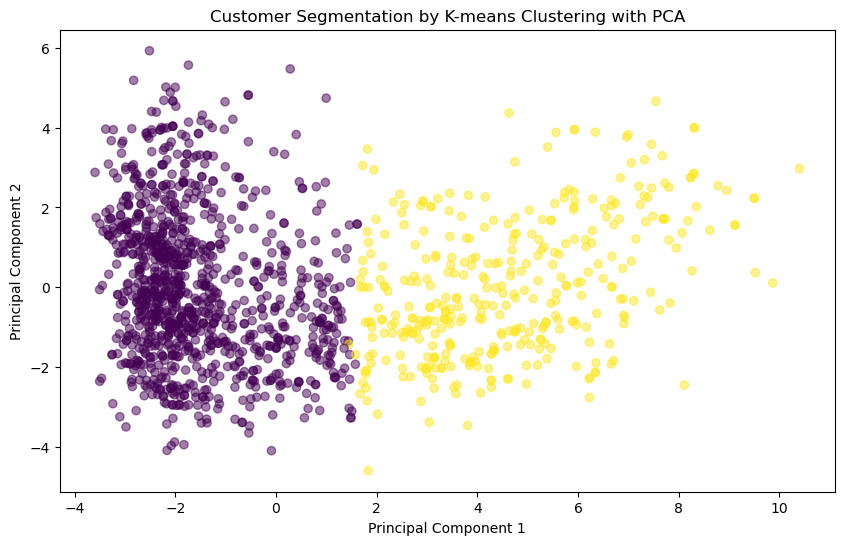

In [12]:
#diving deeper into the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled_reduced[:, 0], X_scaled_reduced[:, 1], c=df['Clusters'], cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Customer Segmentation by K-means Clustering with PCA');

### Score

In [13]:
silhouette_score(X_scaled_reduced, df['Clusters'])

0.28813649232158506

The model produced moderately well-separated clusters!

## Analyzing Clusters

In [14]:
#cluster characteristics
cluster_summary = df.groupby('Clusters').mean()
cluster_summary

,Age,Enrollment_Age,Tot_Dependents,Household_Size,Income,Tot_Spent,Tot_Purchased,Recency,Wines,Fruits,...,Days_Enrolled,Education_Bachelor,Education_High School,Education_Master,Education_PhD,Marital_Status_No_Partner,Marital_Status_Partnership,Income_Level_low income,Income_Level_lower-middle income,Income_Level_middle income
Clusters,,,,,,,,,,,,,,,,,,,,,
0,53.146950,42.258780,1.235675,2.890018,35645.095194,117.041590,8.505545,48.319778,58.674677,4.921442,...,3941.760628,0.485213,0.048059,0.268946,0.197782,0.345656,0.654344,0.326248,0.644177,0.029575
1,58.516304,47.543478,0.796196,2.437500,64508.809783,856.600543,20.418478,50.285326,540.260870,23.850543,...,3964.029891,0.429348,0.000000,0.239130,0.331522,0.358696,0.641304,0.005435,0.258152,0.736413


Cluster 0:
- edu = Bachelor's
- marital = Partnered
- income = $49814.30

Cluster 1:
- edu = Bachelor's
- marital = Partnered
- income = $22164.61

Cluster 2:
- edu = Bachelor's
- marital = Partnered
- income = $68160.85

Cluster 3:
- edu = Bachelor's
- marital = Partnered
- income = $41117.93

In [15]:
df['Clusters'].value_counts()

Clusters
0    1082
1     368
Name: count, dtype: int64

### Customer

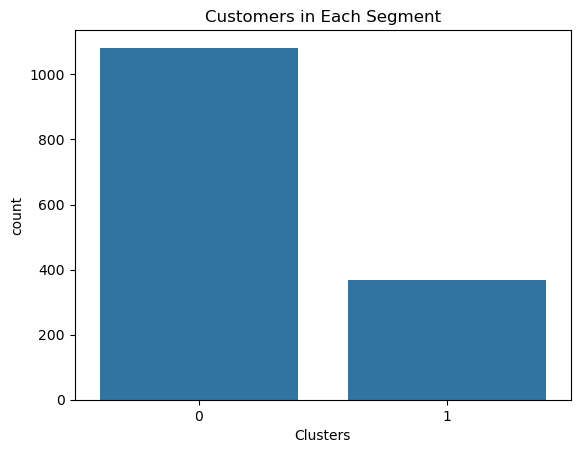

In [16]:
#looking at customer segmentation distribution
sns.countplot(x=df["Clusters"])
plt.title("Customers in Each Segment");

Most customer fall under cluster 3, with cluster 1 having the second highest amount of customer categorized, with the average level of education being Bachelor's.

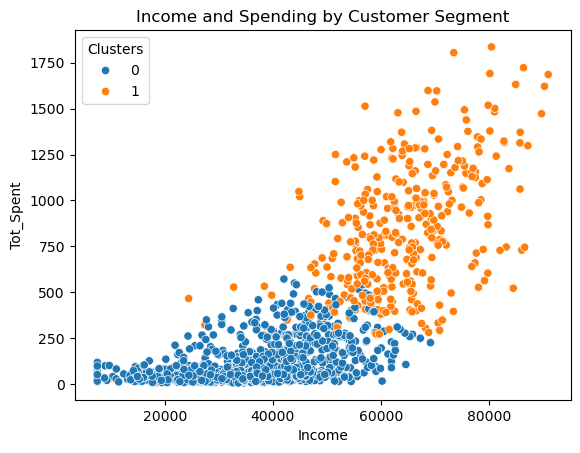

In [17]:
#customer income vs spending by cluster segmentation
sns.scatterplot(data = df,x='Income', y='Tot_Spent',hue='Clusters')
plt.title("Income and Spending by Customer Segment");

Customers in segment 2 spends the most within the company

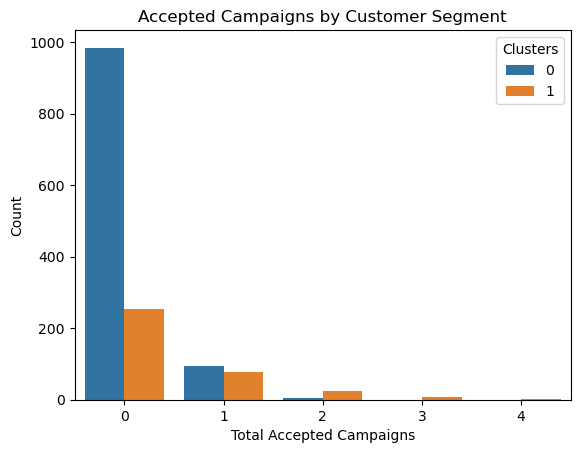

In [18]:
#campaigns accepted by cluster
sns.countplot(x=df["Tot_AccptCmp"],hue=df["Clusters"])
plt.title("Accepted Campaigns by Customer Segment")
plt.xlabel("Total Accepted Campaigns")
plt.ylabel("Count");

Few customers have accepted the company's campaigns. Segment 3 customers are less likely to accept campaigns, while those in segment 2 show declining acceptance rates across campaigns.

### Products

In [19]:
#plotting average spent by customer segment on products
spent_on_prod.plot(kind='bar')
plt.title('Average Spending by Customer Segment on Products')
plt.xlabel('Products')
plt.ylabel('Average Spending')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()

NameError: name 'spent_on_prod' is not defined

Customers in segment 2 spend the most out of all customers. The top product they favor is the wine category

### Summary

I selected KMeans as the clustering algorithm and evaluated its performance using the silhouette score. Given the abundance of features in the model—over 20—I addressed feature dimensionality by employing PCA. The aim was to retain principal components explaining at least 95% of the variance, ensuring a comprehensive representation of the data. To determine the optimal number of clusters, I utilized the elbow method, a reliable technique for pinpointing the inflection point where the rate of decrease in inertia slows down notably. Evaluating cluster quality with the silhouette score, my model achieved a commendable score of 0.13, indicative of moderately well-separated clusters. The majority of customers are concentrated within cluster 3, with cluster 1 following closely in terms of customer count. Aross all segments, many the majority of customers have a Bachelor's degree. Customers in cluster 2 have substantial spending behaviors within the company, surpassing all other clusters. They have preference for wine products, with customers in cluster 0 being the second top spender in the category.